In [1]:
import numpy as np
import os
from tqdm import tqdm
import cv2
import glob
import datetime
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import skimage.io as io
import skimage.transform as trans
from skimage import img_as_ubyte
from keras import backend as K

In [2]:
%load_ext tensorboard

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Segmentation/unet_code
!pwd

/content/drive/MyDrive/Segmentation/unet_code
/content/drive/MyDrive/Segmentation/unet_code


In [5]:
from model import *
from utils import *
from data import *

In [6]:
# print('unet_bn_bw' in dir())

In [ ]:
# def jacard_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [7]:
IMG_WIDTH = IMG_HEIGHT = 256; IMG_CHANNELS = 3
# TRAIN_PATH = 'C:/Users/hanus/Desktop/Manipal/semester_2/CNN/project/segmentation/data/neutrophils/train/'
# TEST_PATH = 'C:/Users/hanus/Desktop/Manipal/semester_2/CNN/project/segmentation/data/neutrophils/test/'
TRAIN_PATH = '/content/drive/MyDrive/Segmentation/data/neutrophils/train/' # colab
TEST_PATH = '/content/drive/MyDrive/Segmentation/data/neutrophils/test/' # colab
train_ids = os.listdir(TRAIN_PATH + 'image/')
test_ids = os.listdir(TEST_PATH + 'image/')

In [ ]:
# X_train, Y_train, X_test, Y_test = load_data(TRAIN_PATH, TEST_PATH, train_ids, test_ids)

In [8]:
# OneDrive_1_5-16-2021
# path_1 = "C:/Users/hanus/Desktop/Manipal/semester_2/CNN/project/unet/unet/dup_data/neutrophils/OneDrive_1_5-16-2021/train/label/"
path_1 = '/content/drive/MyDrive/Segmentation/data/neutrophils/OneDrive_1_5-16-2021/test/label/' # colab
emp_img_list = []
os.chdir(path_1)

for filename in os.listdir(path_1):
    img = imread(filename)
    if np.sum(img) == 0:
        emp_img_list.append(filename)
print("Number of images without ROI: ", len(emp_img_list))

# non_emp_img_list = []
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     if id_ not in emp_img_list:
#         non_emp_img_list.append(id_)

# os.chdir('C:/Users/hanus/Desktop/Manipal/semester_2/CNN/project/unet/unet/data')
print('Resizing training images and masks')
X_train = []
Y_train = []
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    if id_ not in emp_img_list:
        img = imread(TRAIN_PATH + '/image/' + id_)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
        norm_img = np.zeros((800,800))
        img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
        X_train.append(img)
        mask = imread(TRAIN_PATH + '/label/' + id_ )
        mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
        Y_train.append((mask[:,:,0] / 255).reshape(256, 256, 1))
        
print('Resizing test images and masks')
X_test = []
Y_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    if id_ not in emp_img_list:
        img1 = imread(TEST_PATH + '/image/' + id_ )
        img1 = cv2.resize(img1, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
        X_test.append(img1)
        mask1 = imread(TEST_PATH  + '/label/' + id_ )
        mask1 = cv2.resize(mask1, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_NEAREST)
        Y_test.append((mask1[:,:,0] / 255).reshape(256, 256, 1))
        
X_train = np.array(X_train)/255
Y_train = np.array(Y_train)
X_test = np.array(X_test)/255
Y_test = np.array(Y_test)

Number of images without ROI:  0
Resizing training images and masks


100%|██████████| 376/376 [01:18<00:00,  4.76it/s]


Resizing test images and masks


100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


In [9]:
X_train, Y_train = shuffle_data(X_train, Y_train)

In [ ]:
# Y_train  = Y_train[:,:,:,0]
# Y_test  = Y_test[:,:,:,0]
# Y_train = Y_train.reshape(-1, 256, 256, 1)
# Y_test = Y_test.reshape(-1, 256, 256, 1)

In [10]:
print("Shapes :\n======\nX_train = {}\nY_train = {}\nX_test  = {}\nY_test  = {}"
      .format(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape))

Shapes :
X_train = (376, 256, 256, 3)
Y_train = (376, 256, 256, 1)
X_test  = (11, 256, 256, 3)
Y_test  = (11, 256, 256, 1)


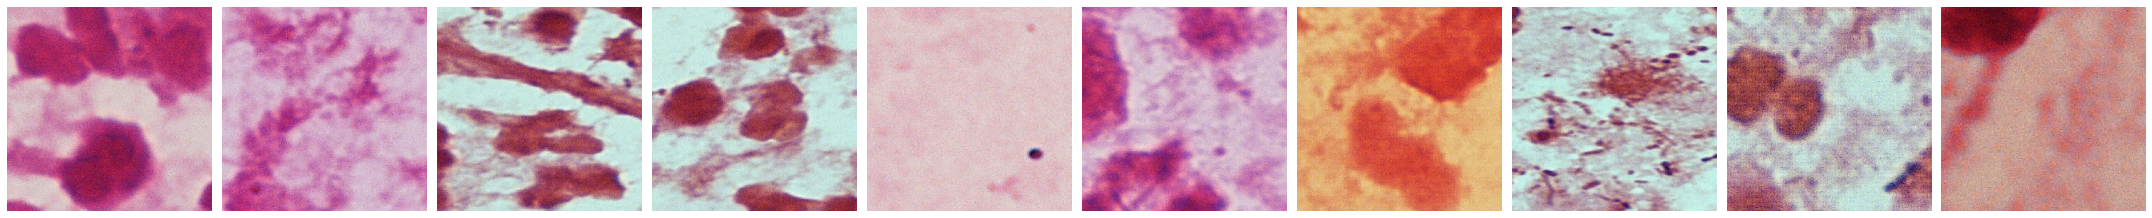

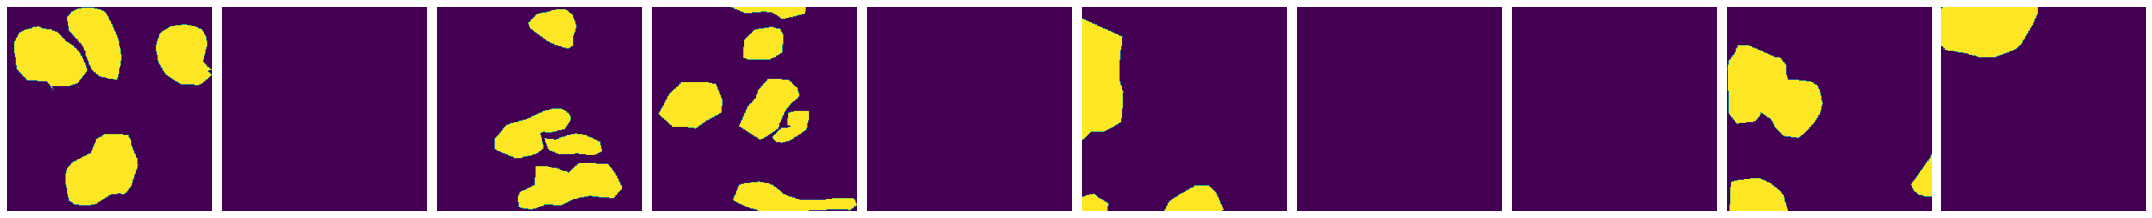

In [11]:
X_train_rot = rotate_image(X_train)
Y_train_rot = rotate_image(Y_train)
plotImages(X_train_rot,10)
plotImages(Y_train_rot[:,:,:,0],10)

In [12]:
print("Shapes :\n======\nX_train = {}\nY_train = {}\nX_test  = {}\nY_test  = {}"
      .format(X_train_rot.shape, Y_train_rot.shape, X_test.shape, Y_test.shape))

Shapes :
X_train = (376, 256, 256, 3)
Y_train = (376, 256, 256, 1)
X_test  = (11, 256, 256, 3)
Y_test  = (11, 256, 256, 1)


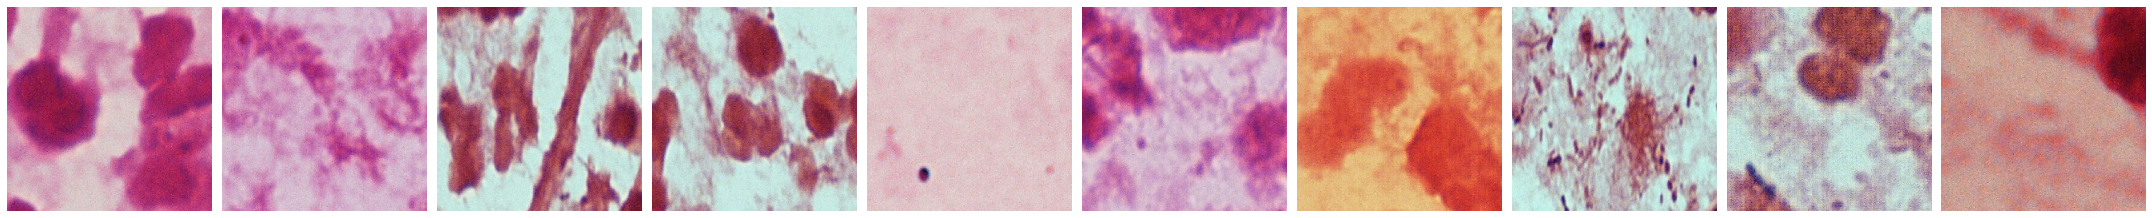

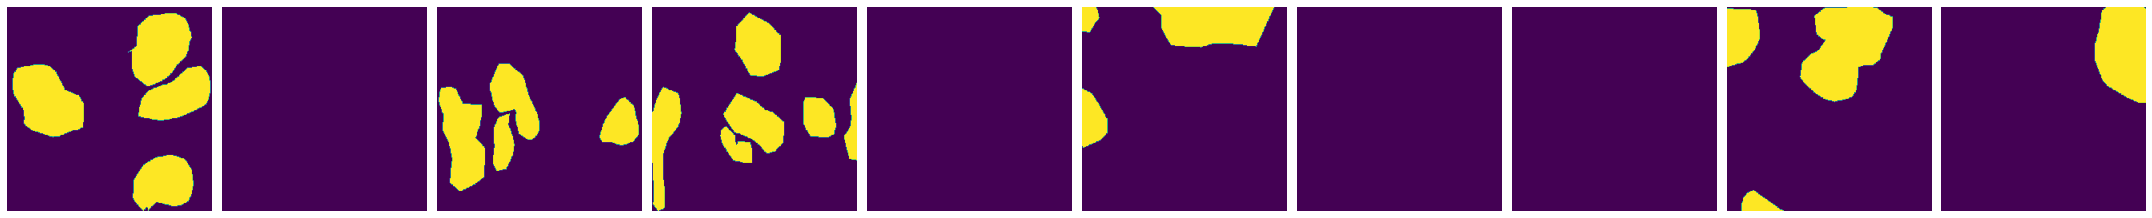

In [13]:
# plot images
plotImages(X_train,10)
plotImages(Y_train[:,:,:,0],10)

In [14]:
X_train_aug = np.concatenate((X_train, X_train_rot), axis=0)
Y_train_aug = np.concatenate((Y_train, Y_train_rot), axis=0)

In [ ]:
X_train_aug, Y_train_aug = shuffle_data(X_train_aug, Y_train_aug)

In [15]:
print("Shapes :\n======\nX_train = {}\nY_train = {}\nX_test  = {}\nY_test  = {}"
      .format(X_train_aug.shape, Y_train_aug.shape, X_test.shape, Y_test.shape))

Shapes :
X_train = (752, 256, 256, 3)
Y_train = (752, 256, 256, 1)
X_test  = (11, 256, 256, 3)
Y_test  = (11, 256, 256, 1)


In [16]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [17]:
help(unet_bn_bw)

Help on function unet_bn_bw in module model:

unet_bn_bw(pretrained_weights=None, input_size=(256, 256, 1))



In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
# data_gen_args = dict()
# myGene = trainGenerator(6, TRAIN_PATH + '/aug/', 'image', 'label', data_gen_args, save_to_dir = None)

In [18]:
##############
# model = small_unet()
model = unet_bn()
##############
epochs = 50
batch_size = 6

In [19]:
log_dir = "/content/drive/MyDrive/Colab/Segmentation/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# checkpointer = tf.keras.callbacks.ModelCheckpoint('unet.h5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(patience = 5, monitor='val_loss')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [earlystopper
             , tensorboard
             # , checkpointer
            ]

results = model.fit(X_train_aug, Y_train_aug
                    , validation_split=0.3
                    , batch_size=batch_size
                    , epochs=epochs
                    , callbacks=callbacks
                    , verbose=1
                   )

Epoch 1/50
88/88 [==============================] - 84s 724ms/step - loss: -0.1022 - jacard_coef: 0.1020 - val_loss: -0.0845 - val_jacard_coef: 0.0838
Epoch 2/50
88/88 [==============================] - 58s 660ms/step - loss: -0.1269 - jacard_coef: 0.1268 - val_loss: -0.0707 - val_jacard_coef: 0.0701
Epoch 3/50
88/88 [==============================] - 60s 685ms/step - loss: -0.1526 - jacard_coef: 0.1524 - val_loss: -0.0715 - val_jacard_coef: 0.0709
Epoch 4/50
88/88 [==============================] - 60s 681ms/step - loss: -0.1811 - jacard_coef: 0.1810 - val_loss: -0.2029 - val_jacard_coef: 0.2012
Epoch 5/50
88/88 [==============================] - 59s 675ms/step - loss: -0.2188 - jacard_coef: 0.2193 - val_loss: -0.2830 - val_jacard_coef: 0.2805
Epoch 6/50
88/88 [==============================] - 55s 627ms/step - loss: -0.2446 - jacard_coef: 0.2450 - val_loss: -0.2686 - val_jacard_coef: 0.2663
Epoch 7/50
88/88 [==============================] - 59s 675ms/step - loss: -0.2446 - jacard_co

KeyboardInterrupt: ignored

In [ ]:
# results.history

In [ ]:
version = "1"
comments = str(input("Comments:"))
model_name = "unet_eps" + str(epochs) + "_bs" + str(batch_size) + "_jaccard_" + "ver"+ version + "_" + comments + ".h5" 

In [ ]:
# model.save_weights("C:/Users/hanus/Desktop/Manipal/semester_2/CNN/project/segmentation/models/" + model_name)
model.save_weights("/content/drive/MyDrive/Colab/Segmentation/models/" + model_name)

OSError: ignored

In [ ]:
model.load_weights("/content/drive/MyDrive/Colab/Segmentation/models/" + model_name)

In [ ]:
###### for plotting accuracy and loss curve for training and validation set
plt.figure( figsize = (25,7) )
plt.subplot(121)
plt.plot(results.history['jacard_coef'], 'b-')
plt.plot(results.history['val_jacard_coef'], 'r-')
plt.title('Model accuracy'); plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(['Training Accuracy'
           , 'Validation Accuracy'
           ])
# plt.show()
# fig.savefig("unet_Accuraccy.png")
#summarize history for loss
plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss'); plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend(['Train'
            , 'Validation'
           ])
plt.tight_layout()
plt.show()
# fig.savefig("unet_Loss.png") 

In [ ]:
preds_test = model.predict(X_test, verbose=1)

preds_test_t = (preds_test > 0.075).astype(np.uint8)

In [ ]:
# plotImages(X_test, 10)
# plotImages(Y_test, 10)
# plotImages(preds_test_t, 10)

In [ ]:
# for i in range(10):
#     # print(i)
#     plt.figure( figsize=(10,3) )
#     plt.subplot(1,3,1)
#     plt.imshow(X_train[i])
#     plt.subplot(132)
#     plt.imshow(Y_train[i])
#     plt.subplot(133)
#     plt.imshow(preds_test_t[i])
#     plt.show()

In [ ]:
def jacard_coef_numpy(y_true, y_pred, smooth=1.0):
    y_true_f = np.ndarray.flatten(y_true)
    y_pred_f = np.ndarray.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth)

In [ ]:
def plotImages(images_arr, num_plots = 5):
    fig, axes = plt.subplots(1, num_plots, figsize=(30, 30))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
print(jacard_coef(X_test[0], X_test[0], 1))

In [ ]:
plotImages(X_test, 10)
plotImages(Y_test[:,:,:,0], 10)
plotImages(preds_test_t[:,:,:,0], 10)
plotImages(preds_test[:,:,:,0], 10)

In [ ]:
for i in range(len(X_test)):
    # print(i)
    plt.figure( figsize=(20,3) )
    plt.subplot(141)
    plt.imshow(X_test[i])
    plt.title('Image')
    plt.subplot(142)
    plt.imshow(Y_test[i][:,:,0])
    plt.title('Mask. Jaccard coeff self:' + str(np.around(jacard_coef_numpy(Y_test[i], Y_test[i]), 3)))
    plt.subplot(143)
    plt.imshow(preds_test_t[i][:,:,0])
    plt.title('Prediction. Jaccard coeff: ' + str(np.around(jacard_coef_numpy(Y_test[i], preds_test_t[i]), 3)))
    plt.subplot(144)
    plt.imshow(preds_test[i][:,:,0])
    plt.title('no threshold mask. Jaccard coeff: ' + str(np.around(jacard_coef_numpy(Y_test[i], preds_test[i]), 3)))
    plt.show()

# Extract and Save ROIs

In [ ]:
print("X_test shape:",preds_test_t.shape)
plotImages(preds_test_t[:,:,:,0], 11)

In [ ]:
preds_test_t_path = '/content/drive/MyDrive/Colab/Segmentation/data/neutrophils/outputs/predicted_masks/'
extracted_rois_path = '/content/drive/MyDrive/Colab/Segmentation/data/neutrophils/outputs/extracted_rois/'

test_img_list = [] # should contain the list of test images
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    if id_ not in emp_img_list:
        test_img_list.append(id_)
# test_img_list

In [ ]:
# num = 2
for img_num in range(len(X_test)):
    # print(num)
    image = X_test[img_num]
    input_msk = preds_test_t[img_num,:,:,0]
    thresh = cv2.erode(input_msk, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    # detect contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    print("contours detected for image {}: {}".format(test_img_list[img_num], len(cnts)))
    # loop over the contours
    image2 = input_msk.copy()
    num = 0
    filename, file_extension = os.path.splitext(test_img_list[img_num])
    path_roi = os.path.join(extracted_rois_path, filename)
    os.mkdir(path_roi)
    for (i, c) in enumerate(cnts):
        # draw the bright spot on the image
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(image2,(x,y),(x+w,y+h),(0, 0, 0), 2)
        roi = input_msk[y:y + h, x:x + w]
        num+=1
        mmm=filename+'_'+str(num)+file_extension
        save_roi_path=os.path.join(path_roi, mmm)
        plt.imsave(save_roi_path,roi, cmap='gray')
    plt.imsave(preds_test_t_path+test_img_list[img_num], input_msk, cmap='gray')    